In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from dwd import download_all_kl_files, read_dwd_kl_file, get_dwd_stations, BASE_URL

%matplotlib inline

In [43]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = f'{n}%'
    return percentile_

In [45]:
stations = get_dwd_stations()

stations['operation_time'] = stations['bis_datum'] - stations['von_datum']
stations = (
    stations
    .query('bis_datum == "2019-06-22"')
    .sort_values('operation_time', ascending=False)
)
stations.head()

,id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,operation_time
472,2290,1781-01-01,2019-06-22,977,47.8009,11.0108,Hohenpeißenberg,Bayern,87099 days
505,2444,1824-01-01,2019-06-22,155,50.9251,11.5830,Jena (Sternwarte),Thüringen,71395 days
821,4024,1853-07-01,2019-06-22,40,54.3643,13.4771,Putbus,Mecklenburg-Vorpommern,60621 days
606,2928,1863-12-01,2019-06-22,138,51.3151,12.4462,Leipzig-Holzhausen,Sachsen,56816 days
1142,5797,1863-12-03,2019-06-22,353,50.6878,12.4329,Lichtentanne,Sachsen,56814 days


In [46]:
download_all_kl_files()

100%|██████████| 1213/1213 [00:32<00:00, 39.42it/s]

In [56]:
from glob import glob

station_data = pd.DataFrame()

for station in stations.itertuples():
    files = glob(f'data/kl/tageswerte_KL_{station.id:05d}_*')
    if not files:
        continue
        
    df = pd.concat([read_dwd_kl_file(f) for f in files])

    by_year = df.groupby(df['MESS_DATUM'].dt.year)['TMK'].agg(
        ['count', 'mean']
    )
    by_year.index.name = 'Jahr'
    station_data[station.id] = by_year.query('count > 350')['mean']

In [39]:
station_data.head()

,2290,2444,4024,2928,5797,2578,1684,3126,853,3946,...,15189,15200,15207,15214,15444,1246,15520,15555,15547,379
Jahr,,,,,,,,,,,,,,,,,,,,,
1781,7.245753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782,5.169589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1783,6.517808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784,4.691803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1785,4.375890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


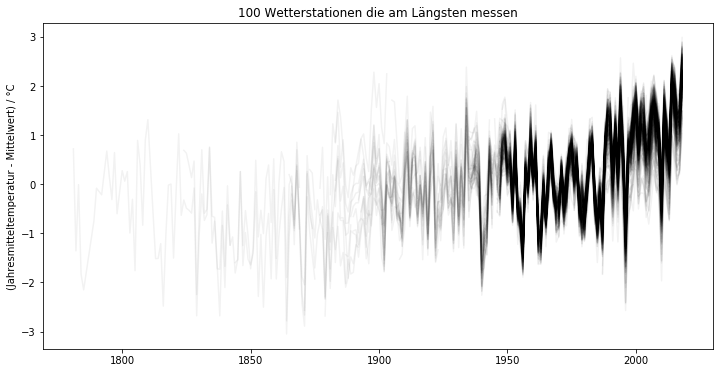

In [41]:
   
plt.figure(figsize=(12, 6))

for c in station_data.columns:
    plt.plot(station_data.index, station_data[c] - station_data[c].loc['1950':'1990'].mean(), color='k', alpha=0.05)

plt.ylabel('(Jahresmitteltemperatur - Mittelwert von 1950 bis 1990) / °C')
plt.xlabel('')
None

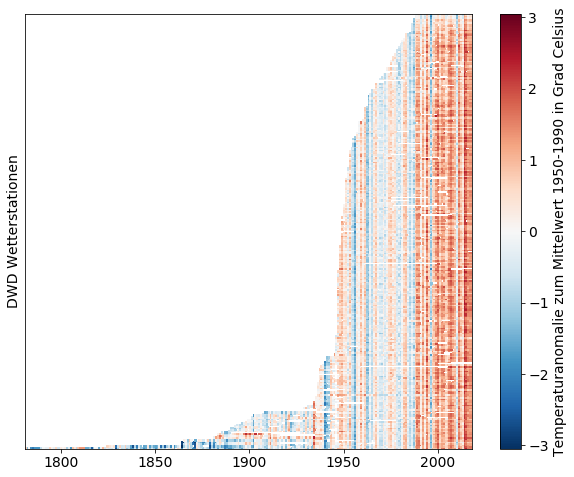

In [76]:
station_data.dropna(thresh=30, axis=1, inplace=True)


data = (station_data.values - station_data.loc['1950':'1990'].mean().values).T
limit = np.nanmax(np.abs(data))

plt.rcParams['font.size'] = 14
plt.figure(figsize=(10, 8))
plt.pcolormesh(
    station_data.index,
    np.arange(len(station_data.columns)),
    data,
    cmap='RdBu_r',
    vmin=-limit,
    vmax=limit,
)
plt.yticks([])
plt.ylabel('DWD Wetterstationen')
plt.colorbar(label='Temperaturanomalie zum Mittelwert 1950-1990 in Grad Celsius')

In [62]:
station_data.count().sort_values()

379        1
15555      2
1886       2
1246       3
1228       3
15444      4
15207      5
2410       5
3254       5
125        5
161        7
7410       7
15000      7
2485       7
342        8
1584       9
7393       9
13700     10
3571      10
13710     10
7396      10
13777     10
13965     10
2953      11
7432      11
7403      11
7420      11
7319      11
7428      11
7431      11
        ... 
1684      80
2014      80
4024      80
755       81
1550      81
5440      81
3730      82
1975      83
656       83
5099      88
445       90
1757      91
1580      95
2486      99
3946     105
3196     105
853      110
3015     112
722      116
5792     117
4625     121
1358     121
880      125
3987     126
691      127
2928     132
2578     135
3126     136
2444     187
2290     231
Length: 491, dtype: int64